<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_18/s18_mnist_conditional_adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts==0.2.5rc1
! pip install --quiet "torchinfo" "lightning-bolts"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 48.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pytorch-lightning-bolts==0.2.5rc1 (from versions: 0.1.0, 0.1.1, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.2.5, 0.3.0, 0.3.1, 0.3.2, 0.3.2.post0, 0.3.2.post1)
ERROR: No matching distribution found for pytorch-lightning-bolts==0.2.5rc1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 8.2 MB/s eta 0:00:00


**Add Imports**

In [2]:
# prerequisites
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as pl
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm
from torchvision.utils import make_grid
import torchvision.transforms.functional as ttf

**Define Classifier Model**

In [3]:
class LayerNormalization(nn.Module):

    def __init__(self, eps:float=1E-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1)) # alpha, learnable mean
        self.bias = nn.Parameter(torch.zeros(1)) # bias, learnable bias

    def forward(self,x):
        # x: (batch_size, seq_len, hidden_size)
        # Keep the dimension for broadcasting
        mean = x.mean(dim=-1, keepdim=True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim=-1, keepdim=True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha*(x-mean)/(std+self.eps) + self.bias


class MNIST_Classifier(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, output_dim=10):
        super().__init__()
        self.fc_1 = nn.Sequential(nn.Linear(input_dim, hidden_dim, bias=False),
                                    nn.Dropout(0.1),
                                    nn.ReLU())
        self.fc_2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=False),
                                    nn.Dropout(0.1),
                                    nn.ReLU())
        self.fc_3 = nn.Sequential(nn.Linear(hidden_dim, output_dim, bias=False), nn.ReLU())
        self.norm = LayerNormalization()

    def forward(self, x):
        x = self.norm(self.fc_1(x))
        x = self.norm(self.fc_2(x))
        x = self.norm(self.fc_3(x))
        return F.log_softmax(x, dim=1)


**Train and save the classifier model**

In [4]:

def train_mnist_classifier(num_epochs = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
    torch.manual_seed(1)
    batch_size = 128
    kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    model = MNIST_Classifier().to(device)
    mnist_optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #mnist_scheduler = optim.lr_scheduler.StepLR(mnist_optimizer, step_size=8, gamma=0.1, verbose=True)
    for epoch in range(1, num_epochs+1):
        print(f"epoch: {epoch}")
        model.train()
        pbar = tqdm(train_loader)
        train_loss = 0
        correct = 0
        processed = 0
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            data = torch.flatten(data, start_dim=1)
            mnist_optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            train_loss += loss.item()
            loss.backward()
            mnist_optimizer.step()
            correct += output.argmax(dim=1).eq(target).sum().item()
            processed += len(data)
            pbar.set_description(
                desc=f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100 * correct / processed:0.2f}')
        #mnist_scheduler.step()
    torch.save(model.state_dict(), 'classifier_model.pth')
    return model

**Define VAE model**

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, num_labels=10, label_enc_dim=28):
        super(VAE, self).__init__()

        # label embedding
        self.label_enc_dim = label_enc_dim
        self.num_labels = num_labels
        self.class_embeddings = nn.Embedding(self.num_labels, self.label_enc_dim)

        # encoder part
        self.enc_inp_dim = x_dim+(self.num_labels*self.label_enc_dim)
        self.fc1 = nn.Linear(self.enc_inp_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.dec_inp_dim = z_dim + (self.num_labels*self.label_enc_dim)
        self.fc4 = nn.Linear(self.dec_inp_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z, label):
        label_enc = self.get_label_embedding(label)
        z = torch.cat([z, label_enc], dim=1)
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def get_label_embedding(self, label):
        label_one_hot = torch.nn.functional.one_hot(label, num_classes=10)
        label_enc = self.class_embeddings(label_one_hot)
        label_enc = torch.flatten(label_enc, start_dim=1)
        return label_enc


    def forward(self, x, label):
        x = x.view(-1, 784)
        label_enc = self.get_label_embedding(label)
        x = torch.cat([x, label_enc], dim=1)
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z, label), mu, log_var

**Define Loss Function for both reconstruction and adversarial**

In [6]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# return classifier loss
def get_classifier_loss(epoch, x, labels, adversarial_prob=0.5, classifier_model=None):
    # randomly shuffle labels
    if np.random.random() > 1. - adversarial_prob:
        # With view
        idx = torch.randperm(labels.nelement())
        labels = labels.view(-1)[idx].view(labels.size())
    #if epoch == 10:
    #    print("epoch 10")
    classifier_preds = classifier_model(x)
    classifier_loss = nn.functional.cross_entropy(torch.exp(classifier_preds), labels)
    return classifier_loss

**Define train and test functions**

In [10]:
def build_and_train_vae_model(train_loader, test_loader, classifier_model=None, num_epochs=100, use_adversarial=True, adversarial_prob=0.5):
    # build model
    vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)
    if torch.cuda.is_available():
        vae.to(device)

    optimizer = optim.Adam(vae.parameters(), lr=1e-4)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.01,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=5/num_epochs,
        div_factor=100,
        three_phase=True,
        final_div_factor=1,
        anneal_strategy='linear'
    )

    for epoch in range(0, num_epochs):
        vae.train()
        train_loss = 0
        recon_loss = 0
        classifier_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            global_step = batch_idx+epoch*len(train_loader)
            writer.add_scalar("LR", scheduler.get_last_lr()[0], global_step)
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var = vae(data, labels)
            this_recon_loss = loss_function(recon_batch, data, mu, log_var)

            if use_adversarial:
                this_classifier_loss = get_classifier_loss(epoch, recon_batch.to(device), labels, adversarial_prob=adversarial_prob, classifier_model=classifier_model)
                loss = 0.01*this_recon_loss + 100*this_classifier_loss
            else:
                loss = this_recon_loss
                this_classifier_loss=None

            train_loss += loss.item()
            if this_classifier_loss is not None:
                classifier_loss += this_classifier_loss.item()

            recon_loss += this_recon_loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

            writer.add_scalar("Total_Loss", loss.item(), global_step)
            writer.add_scalar("Classifier_Loss", this_classifier_loss.item(), global_step)
            writer.add_scalar("Recon_Loss", this_recon_loss.item(), global_step)

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_recon_loss = recon_loss / len(train_loader.dataset)
        avg_classifier_loss = classifier_loss / len(train_loader.dataset)
        print('====> Epoch: {} Total loss: {:.4f} Recon loss: {:.4f} Classifier loss: {:.4f}'.format(epoch, avg_train_loss, avg_recon_loss, avg_classifier_loss))
        #test(test_loader, vae, epoch)
    return vae


def test(test_loader, vae, epoch):
    vae.eval()
    test_loss = 0
    tgt_labels = torch.arange(10, dtype=torch.int64)
    outputs = []
    data, labels = next(iter(test_loader))
    x = data[0].unsqueeze(0).to(device)
    with torch.no_grad():
        for lbl in tgt_labels:
            for _ in tgt_labels:
                op, *_ = vae(x, lbl.unsqueeze(0).to(device))
                outputs.append(op.view(1,28,28))
    final_op = torch.vstack(outputs).unsqueeze(1)
    save_image(final_op, f'./samples/sample_{epoch}.png')
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

**Define supporting functions**

In [8]:
def get_loaders(batch_size):
    # MNIST Dataset
    train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


def get_classifier_model(train_classifier, model_path):
    if train_classifier:
        trained_classifier_model = train_mnist_classifier(num_epochs=10)
    else:
        trained_classifier_model = MNIST_Classifier()
        trained_classifier_model.load_state_dict(torch.load(model_path))
    return trained_classifier_model

def show_image(img_tensor):
    np_op_img = np.asarray(img_tensor.detach().cpu()).squeeze()
    pl.figure()
    pl.imshow(np_op_img, cmap='gray')
    pl.colorbar()
    pl.show()

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = pl.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = ttf.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    pl.show()



def generate_image(x, label):
    gen_img_tensor, *_ = vae(x, torch.tensor(label, dtype=torch.int64).unsqueeze(0).cuda())
    gen_img_tensor = gen_img_tensor.view((1,28,28))
    show_image(gen_img_tensor)
    return gen_img_tensor


def conditional_generation(vae, test_loader, num_images=32, interp_weight=0.1):
    data, label = next(iter(test_loader))
    data = data.cuda()
    label = label.cuda()
    gen_images = []
    for cnt in range(num_images):
        x = data[cnt].view(-1, 784)
        l = label[cnt].unsqueeze(0)
        l_e = vae.get_label_embedding(l)
        x_l = torch.cat([x, l_e], dim=1)

        with torch.no_grad():
            # get mean and std of given image and label
            mu0, log_var0 = vae.encoder(x_l)
            z0 = vae.sampling(mu0, log_var0)

            # draw a random value of mean and std from standard gaussian
            shuffled_label_val = np.random.choice(np.arange(10, dtype=int))
            shuffled_label = torch.tensor(shuffled_label_val, dtype=torch.int64).unsqueeze(0).cuda()
            z1 = torch.randn(1, 2).cuda()

            z_interp = torch.lerp(z0, z1, weight=interp_weight)
            img_tensor = vae.decoder(z_interp, shuffled_label).view(1, 28, 28)
            gen_images.append(img_tensor)
    final_output = torch.vstack(gen_images)#.unsqueeze(1)
    grid = make_grid(gen_images)
    show(grid)
    print(final_output.shape)
    return final_output


**Run the whole flow**

In [11]:
#use_cuda = True if torch.cuda.is_available() else False
use_cuda=True
device = torch.device("cuda" if use_cuda else "cpu")
writer = SummaryWriter()

train_classifier = False
model_path = 'classifier_model.pth'
trained_classifier_model = get_classifier_model(train_classifier, model_path)
trained_classifier_model.to(device)
trained_classifier_model.eval()

bs = 64
train_loader, test_loader = get_loaders(bs)
vae = build_and_train_vae_model(train_loader, test_loader, num_epochs=40, classifier_model=trained_classifier_model)

====> Epoch: 0 Total loss: 5.0234 Recon loss: 187.3243 Classifier loss: 0.0315
====> Epoch: 1 Total loss: 4.4894 Recon loss: 145.2743 Classifier loss: 0.0304
====> Epoch: 2 Total loss: 4.3737 Recon loss: 139.2085 Classifier loss: 0.0298
====> Epoch: 3 Total loss: 4.3691 Recon loss: 136.8953 Classifier loss: 0.0300
====> Epoch: 4 Total loss: 4.3399 Recon loss: 136.3784 Classifier loss: 0.0298
====> Epoch: 5 Total loss: 4.2926 Recon loss: 135.0019 Classifier loss: 0.0294
====> Epoch: 6 Total loss: 4.2993 Recon loss: 133.6024 Classifier loss: 0.0296
====> Epoch: 7 Total loss: 4.3150 Recon loss: 131.9037 Classifier loss: 0.0300
====> Epoch: 8 Total loss: 4.2971 Recon loss: 130.6307 Classifier loss: 0.0299
====> Epoch: 9 Total loss: 4.2440 Recon loss: 129.2879 Classifier loss: 0.0295
====> Epoch: 10 Total loss: 4.2865 Recon loss: 128.5024 Classifier loss: 0.0300
====> Epoch: 11 Total loss: 4.2764 Recon loss: 128.4464 Classifier loss: 0.0299
====> Epoch: 12 Total loss: 4.2687 Recon loss: 128

**Generate Images**

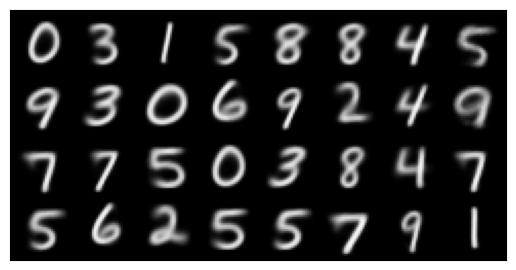

torch.Size([32, 28, 28])


In [13]:
op = conditional_generation(vae, test_loader, num_images=32, interp_weight=0.5)
